In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
print("슝=3")
#기본적으로 필요한 라이브러리 임폴트 하고 이번에 자료가 csv형태로 주어졌는데 어떻게 되어있는지 표 형태로 보기 위해서 판다스 pd 임폴트

슝=3


In [2]:
# 포지셔널 인코딩 레이어
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 재배열
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("슝=3")

슝=3


In [3]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("슝=3")

슝=3


In [4]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결(concatenate)합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs
print("슝=3")

슝=3


In [5]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("슝=3")

슝=3


In [6]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("슝=3")

슝=3


In [7]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [8]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("슝=3")

슝=3


In [9]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [10]:
def decoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name='decoder'):
  inputs = tf.keras.Input(shape=(None,), name='inputs')
  enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name='look_ahead_mask')

  # 패딩 마스크
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')
  
  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  # Dropout이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  for i in range(num_layers):
    outputs = decoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name='decoder_layer_{}'.format(i),
    )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("슝=3")

슝=3


In [11]:
data = pd.read_csv('~/aiffel/transformer_chatbot/data/ChatbotData.csv')#데이터를 pd로 열어 표 형태로 보았다. Q, A, laber로 이루어져 있었다.
data.head() #우리에게 중요한건 Q와 A

,Q,A,label
0,12시 땡!,하루가 또 가네요.,0
1,1지망 학교 떨어졌어,위로해 드립니다.,0
2,3박4일 놀러가고 싶다,여행은 언제나 좋죠.,0
3,3박4일 정도 놀러가고 싶다,여행은 언제나 좋죠.,0
4,PPL 심하네,눈살이 찌푸려지죠.,0


In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11823 entries, 0 to 11822
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Q       11823 non-null  object
 1   A       11823 non-null  object
 2   label   11823 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 277.2+ KB


In [13]:
data.isnull().sum()#결측치를 찾아 보았다.

Q        0
A        0
label    0
dtype: int64

In [14]:
data=data.drop_duplicates()#결측치 제거

In [15]:
# 전처리 함수
def preprocess_sentence(sentence):
  sentence = sentence.lower().strip()

  # 단어와 구두점(punctuation) 사이의 거리를 만듭니다.
  # 예를 들어서 "I am a student." => "I am a student ."와 같이
  # student와 온점 사이에 거리를 만듭니다.
  sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
  sentence = re.sub(r'[" "]+', " ", sentence)

  # (ㄱ-ㅣ, 가-힣, a-z, A-Z, ".", "?", "!", ",")를 제외한 모든 문자를 공백인 ' '로 대체합니다.
  sentence = re.sub(r"[^ㄱ-ㅣ가-힣,a-zA-Z?.!,]+", " ", sentence)
  sentence = sentence.strip()
  return sentence
print("슝=3")

슝=3


In [16]:
q1=data["Q"].map(lambda x: preprocess_sentence(x)) # 전처리함수 적용 map함수에 람다 함수를 사용하여 전처리를 하여 저장.
a1=data["A"].map(lambda x: preprocess_sentence(x)) 
print('전체 샘플 수 :', len(q1))
print('전체 샘플 수 :', len(a1))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [17]:
def remove_stopwords(seq):#RANKS NL의 한국어 stop words를 참조 불용어를 제거를 위해 리스트를 만듬 
    stopwords=['아', '휴',"휴우", '아이구', '아이쿠', '아이고', '어', '나', '우리', 
               '저희', '따라', '의해', '을', '를', '에', '의', '가', '으로', 
               '로', '에게', '뿐이다', '의거하여', '근거하여', '입각하여', '기준으로', 
               '예하면', '예를 들면', '예를 들자면', '저', '소인', '소생', '저희', 
               '지말고', '하지마', '하지마라', '다른', '물론', '또한', '그리고', '비길수 없다',
               '해서는 안된다', '뿐만 아니라', '만이 아니다', '만은 아니다', '막론하고', '관계없이', 
               '그치지 않다', '그러나', '그런데', '하지만', '든간에', '논하지 않다', '따지지 않다', 
               '설사', '비록', '더라도', '아니면', '만 못하다', '하는 편이 낫다', '불문하고', '향하여', 
               '향해서', '향하다', '쪽으로', '틈타', '이용하여', '타다', '오르다', '제외하고', '이 외에', 
               '이 밖에', '하여야', '비로소', '한다면 몰라도', '외에도', '이곳', '여기', '부터', 
               '기점으로', '따라서', '할 생각이다', '하려고하다', '이리하여', '그리하여', 
               '그렇게 함으로써', '하지만', '일때', '할때', '앞에서', '중에서', '보는데서', '으로써', 
               '로써', '까지', '해야한다', '일것이다', '반드시', '할줄알다', '할수있다', '할수있어', 
               '임에 틀림없다', '한다면', '등', '등등', '제', '겨우', '단지', '다만', '할뿐', '딩동', 
               '댕그', '대해서', '대하여', '대하면', '훨씬', '얼마나', '얼마만큼', '얼마큼', '남짓', 
               '여', '얼마간', '약간', '다소', '좀', '조금', '다수', '몇', '얼마', '지만', '하물며', 
               '또한', '그러나', '그렇지만', '하지만', '이외에도', '대해 말하자면', '뿐이다', '다음에', 
               '반대로', '반대로 말하자면', '이와 반대로', '바꾸어서 말하면', '바꾸어서 한다면', '만약', 
               '그렇지않으면', '까악', '툭', '딱', '삐걱거리다', '보드득', '비걱거리다', '꽈당', '응당', 
               '해야한다', '에 가서', '각', '각각', '여러분', '각종', '각자', '제각기', '하도록하다', 
               '와', '과', '그러므로', '그래서', '고로', '한 까닭에', '하기 때문에', '거니와', '이지만', 
               '대하여', '관하여', '관한', '과연', '실로', '아니나다를가', '생각한대로', '진짜로', '한적이있다', 
               '하곤하였다', '하', '하하', '허허', '아하', '거바', '와', '오', '왜', '어째서', '무엇때문에', '어찌', '하겠는가', 
               '무슨', '어디', '어느곳', '더군다나', '하물며', '더욱이는', '어느때', '언제', '야', '이봐', '어이', '여보시오', 
               '흐흐', '흥', '휴', '헉헉', '헐떡헐떡', '영차', '여차', '어기여차', '끙끙', '아야', '앗', '아야', '콸콸', '졸졸', 
               '좍좍', '뚝뚝', '주룩주룩', '솨', '우르르', '그래도', '또', '그리고', '바꾸어말하면', '바꾸어말하자면', '혹은', 
               '혹시', '답다', '및', '그에 따르는', '때가 되어', '즉', '지든지', '설령', '가령', '하더라도', '할지라도', '일지라도', 
               '지든지', '몇', '거의', '하마터면', '인젠', '이젠', '된바에야', '된이상', '만큼','어찌됏든', '그위에', '게다가', 
               '점에서 보아', '비추어 보아', '고려하면', '하게될것이다', '일것이다', '비교적', '좀', '보다더', '비하면', '시키다', 
               '하게하다', '할만하다', '의해서', '연이서', '이어서', '잇따라', '뒤따라', '뒤이어', '결국', '의지하여', '기대여',
               '통하여', '자마자', '더욱더', '불구하고', '얼마든지', '마음대로', '주저하지 않고', '곧', '즉시', '바로', '당장', 
               '하자마자', '밖에 안된다', '하면된다', '그래', '그렇지', '요컨대', '다시 말하자면', '바꿔 말하면', '즉', '구체적으로',
               '말하자면', '시작하여', '시초에', '이상', '허', '헉', '허걱', '바와같이', '해도좋다', '해도된다', '게다가', '더구나',
               '하물며', '와르르', '팍', '퍽', '펄렁', '동안', '이래', '하고있었다', '이었다', '에서', '로부터', '까지', '예하면', 
               '했어요', '해요', '함께', '같이', '더불어', '마저', '마저도', '양자', '모두', '습니다', '가까스로', '하려고하다', '즈음하여', '다른', '다른 방면으로', '해봐요', '습니까', '했어요', '말할것도 없고', '무릎쓰고', '개의치않고', '하는것만 못하다', '하는것이 낫다', '매', '매번', '들', '모', '어느것', '어느', '로써', '갖고말하자면', '어디', '어느쪽', '어느것', '어느해', '어느 년도', '라 해도', '언젠가', '어떤것', '어느것', '저기', '저쪽', '저것', '그때', '그럼', '그러면', '요만한걸', '그래', '그때', '저것만큼', '그저', '이르기까지', '할 줄 안다', '할 힘이 있다', '너', '너희', '당신', '어찌', '설마', '차라리', '할지언정', '할지라도', '할망정', '할지언정', '구토하다', '게우다', '토하다', '메쓰겁다', '옆사람', '퉤', '쳇', '의거하여', '근거하여', '의해', '따라', '힘입어', '그', '다음', '버금', '두번째로', '기타', '첫번째로', '나머지는', '그중에서', '견지에서', '형식으로 쓰여', '입장에서', '위해서', '단지', '의해되다', '하도록시키다', '뿐만아니라', '반대로', '전후', '전자', '앞의것', '잠시', '잠깐', '하면서', '그렇지만', '다음에', '그러한즉', '그런즉', '남들', '아무거나', '어찌하든지', '같다', '비슷하다', '예컨대', '이럴정도로', '어떻게', '만약', '만일', '위에서 서술한바와같이', '인 듯하다', '하지 않는다면', '만약에', '무엇', '무슨', '어느', '어떤', '아래윗', '조차', '한데', '그럼에도 불구하고', '여전히', '심지어', '까지도', '조차도', '하지 않도록', '않기 위하여', '때', '시각', '무렵', '시간', '동안', '어때', '어떠한', '하여금', '네', '예', '우선', '누구', '누가 알겠는가', '아무도', '줄은모른다', '줄은 몰랏다', '하는 김에', '겸사겸사', '하는바', '그런 까닭에', '한 이유는', '그러니', '그러니까', '때문에', '그', '너희', '그들', '너희들', '타인', '것', '것들', '너', '위하여', '공동으로', '동시에', '하기 위하여', '어찌하여', '무엇때문에', '붕붕', '윙윙', '나', '우리', '엉엉', '휘익', '윙윙', '오호', '아하', '어쨋든', '만 못하다\t하기보다는', '차라리', '하는 편이 낫다', '흐흐', '놀라다', '상대적으로 말하자면', '마치', '아니라면', '쉿', '그렇지 않으면', '그렇지 않다면', '안 그러면', '아니었다면', '하든지', '아니면', '이라면', '좋아', '알았어', '하는것도', '그만이다', '어쩔수 없다', '하나', '일', '일반적으로', '일단', '한켠으로는', '오자마자', '이렇게되면', '이와같다면', '전부', '한마디', '한항목', '근거로', '하기에', '아울러', '하지 않도록', '않기 위해서', '이르기까지', '이 되다', '로 인하여', '까닭으로', '이유만으로', '이로 인하여', '그래서', '이 때문에', '그러므로', '그런 까닭에', '알 수 있다', '결론을 낼 수 있다', '으로 인하여', '있다', '어떤것', '관계가 있다', '관련이 있다', '연관되다', '어떤것들', '에 대해', '이리하여', '그리하여', '여부', '하기보다는', '하느니', '하면 할수록', '운운', '이러이러하다', '하구나', '하도다', '다시말하면', '다음으로', '에 있다', '에 달려 있다', '우리', '우리들', '오히려', '하기는한데', '어떻게', '어떻해', '어찌됏어', '어때', '어째서', '본대로', '자', '이', '이쪽', '여기', '이것', '이번', '이렇게말하자면', '이런', '이러한', '이와 같은', '요만큼', '요만한 것', '얼마 안 되는 것', '이만큼', '이 정도의', '이렇게 많은 것', '이와 같다', '이때', '이렇구나', '것과 같이', '끼익', '삐걱', '따위', '와 같은 사람들', '부류의 사람들', '왜냐하면', '중의하나', '오직', '오로지', '에 한하다', '하기만 하면', '도착하다', '까지 미치다', '도달하다', '정도에 이르다', '할 지경이다', '결과에 이르다', '관해서는', '여러분', '하고 있다', '한 후', '혼자', '자기', '자기집', '자신', '우에 종합한것과같이', '총적으로 보면', '총적으로 말하면', '총적으로', '대로 하다', '으로서', '참', '그만이다', '할 따름이다', '쿵', '탕탕', '쾅쾅', '둥둥', '봐', '봐라', '아이야', '아니', '와아', '응', '아이', '참나', '년', '월', '일', '령', '영', '일', '이', '삼', '사', '오', '육', '륙', '칠', '팔', '구', '이천육', '이천칠', '이천팔', '이천구', '하나', '둘', '셋', '넷', '다섯', '여섯', '일곱', '여덟', '아홉', '령', '영']
    for i in seq:
        if i in stopwords:
            seq.pop(seq.index(i))
    return seq

In [18]:
#불용어는 단어 단위, 각 문장을 띄어쓰기 단위로 잘라 단어 형태로 만든다.
q2=q1.map(lambda x: x.split(" ")) 
a2=a1.map(lambda x: x.split(" "))
print('ㄱㄱ')

ㄱㄱ


In [19]:
q3=q2.map(lambda x: remove_stopwords(x))#불용어 제거
a3=a2.map(lambda x: remove_stopwords(x))
print('ㄱㄱ')

ㄱㄱ


In [20]:
q4 = [" ".join(i) for i in q3]#불용어를 제거한 질문과 답변을 문장으로 만든다.
a4 = [" ".join(i) for i in a3]
print('ㄱㄱ')

ㄱㄱ


In [21]:
import tensorflow_datasets as tfds
print("살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성. (Tensorflow 2.3.0 이상) (클라우드는 2.4 입니다)
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(q4 + a4, target_vocab_size=2**13)
print("슝=3 ")

살짝 오래 걸릴 수 있어요. 스트레칭 한 번 해볼까요? 👐
슝=3 


In [22]:
import tensorflow_datasets as tfds
print("슝=3 ")

슝=3 


In [23]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("슝=3")

슝=3


In [24]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8077]
END_TOKEN의 번호 : [8078]


In [25]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정합니다.
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8079


질문의 최소 길이 : 0
질문의 최대 길이 : 16
질문의 평균 길이 : 3.7198680537934536
대답의 최소 길이 : 0
대답의 최대 길이 : 22
대답의 평균 길이 : 4.5480842425780255


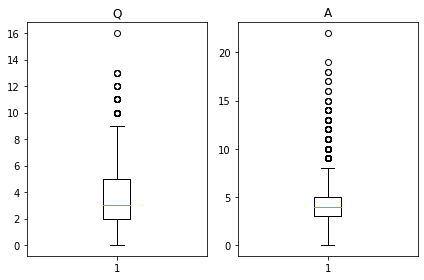

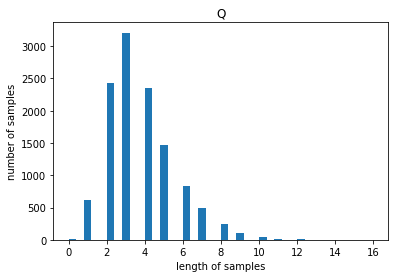

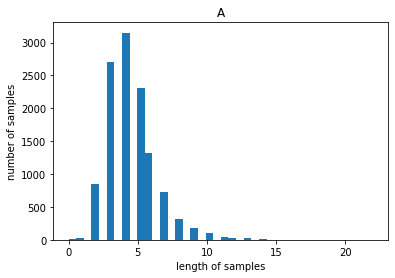

In [26]:
import matplotlib.pyplot as plt

q_len = [len(s.split()) for s in q4]
a_len = [len(s.split()) for s in a4]

print('질문의 최소 길이 : {}'.format(np.min(q_len)))
print('질문의 최대 길이 : {}'.format(np.max(q_len)))
print('질문의 평균 길이 : {}'.format(np.mean(q_len)))
print('대답의 최소 길이 : {}'.format(np.min(a_len)))
print('대답의 최대 길이 : {}'.format(np.max(a_len)))
print('대답의 평균 길이 : {}'.format(np.mean(a_len)))

plt.subplot(1,2,1)
plt.boxplot(q_len)
plt.title('Q')
plt.subplot(1,2,2)
plt.boxplot(a_len)
plt.title('A')
plt.tight_layout()
plt.show()

plt.title('Q')
plt.hist(q_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('A')
plt.hist(a_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show() #이런형태로 질문과 답변이 부포하는것을 알았다. 가장 긴 22에 토큰들을 포함하여 최대길이를 24로 정하였다.

In [27]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이
MAX_LENGTH = 24
print(MAX_LENGTH)

24


In [28]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 17 이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 40으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("슝=3")

슝=3


In [29]:
questions, answers = tokenize_and_filter(q4, a4)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8079
필터링 후의 질문 샘플 개수: 11819
필터링 후의 답변 샘플 개수: 11819


In [30]:
#질문과 답변의 쌍을 tf.data.Dataset API의 입력으로 사용하여 파이프라인을 구성합니다. 
#이때, 교사 강요를 위해서 answers[:, :-1]를 디코더의 입력값, answers[:, 1:]를 디코더의 레이블로 사용

BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("슝=3")

슝=3


In [31]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("슝=3")

슝=3


In [32]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3122432     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

In [33]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("슝=3")

슝=3


In [34]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):#커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("슝=3")

슝=3


Text(0.5, 0, 'Train Step')

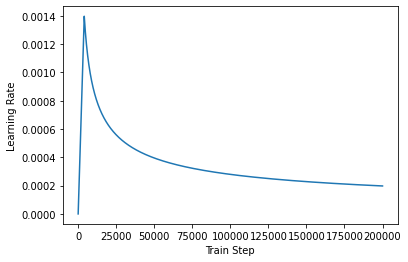

In [35]:
sample_learning_rate = CustomSchedule(d_model=128)#시각화 러닝 레이트에 커스텀 학습률이 잘 적용된 것을 확인

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

In [36]:
learning_rate = CustomSchedule(D_MODEL)#손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("슝=3")

슝=3


In [37]:
EPOCHS = 60#20회 epoch일때 8s 41ms/step - loss: 0.0756 - accuracy: 0.2716 거의 되지않아 epochs를 60늘리도록 하였다.
model.fit(dataset, epochs=EPOCHS, verbose=1)#60회를 돌렸는데 정확도는 올라갔지만 오버피팅이 되지 않았나 걱정이다.

Epoch 1/60
185/185 [==============================] - 14s 41ms/step - loss: 2.4085 - accuracy: 0.0384
Epoch 2/60
185/185 [==============================] - 8s 41ms/step - loss: 1.9466 - accuracy: 0.0837
Epoch 3/60
185/185 [==============================] - 8s 41ms/step - loss: 1.6498 - accuracy: 0.0860
Epoch 4/60
185/185 [==============================] - 8s 41ms/step - loss: 1.5254 - accuracy: 0.0912
Epoch 5/60
185/185 [==============================] - 8s 41ms/step - loss: 1.4315 - accuracy: 0.0967
Epoch 6/60
185/185 [==============================] - 8s 41ms/step - loss: 1.3333 - accuracy: 0.1038
Epoch 7/60
185/185 [==============================] - 8s 41ms/step - loss: 1.2244 - accuracy: 0.1133
Epoch 8/60
185/185 [==============================] - 8s 41ms/step - loss: 1.1036 - accuracy: 0.1263
Epoch 9/60
185/185 [==============================] - 8s 41ms/step - loss: 0.9748 - accuracy: 0.1399
Epoch 10/60
185/185 [==============================] - 8s 41ms/step - loss: 0.8379 - accur

In [38]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("슝=3")

슝=3


In [39]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("슝=3")

슝=3


In [40]:
sentence_generation('퇴근하고 싶다')

입력 : 퇴근하고 싶다
출력 : 몸과 마음이 쉬어야 할 같아요 .


'몸과 마음이 쉬어야 할 같아요 .'

In [41]:
sentence_generation('시험을 망쳤어')

입력 : 시험을 망쳤어
출력 : 컨디션 조절 하세요 .


'컨디션 조절 하세요 .'

In [42]:
sentence_generation('사랑하는 사람이 생겼어')

입력 : 사랑하는 사람이 생겼어
출력 : 축하해요 . 예쁜 사랑하길 바라요 .


'축하해요 . 예쁜 사랑하길 바라요 .'

In [43]:
sentence_generation('쉬고 싶다')

입력 : 쉬고 싶다
출력 : 내려 놓으세요 .


'내려 놓으세요 .'

In [44]:
sentence_generation('난 운동을 좋아해')

입력 : 난 운동을 좋아해
출력 : 원치 않으면 싫다고 말하세요 .


'원치 않으면 싫다고 말하세요 .'

In [45]:
sentence_generation('오늘 뭐 먹을까')

입력 : 오늘 뭐 먹을까
출력 : 맛있는 거 드세요 .


'맛있는 거 드세요 .'

In [46]:
sentence_generation('책 읽기 지겨워')

입력 : 책 읽기 지겨워
출력 : 도서관 데이트나 서점 데이트 좋을 거 같아요 .


'도서관 데이트나 서점 데이트 좋을 거 같아요 .'

In [ ]:
#20회를 돌렸을때 보다는 좋아진거 같다. 하지만 60회나 돌렸는데 로스는 줄어드는 반면에 정확도는 0.28애서 계소 정체된것을 볼 수 있었다. 기본
#적인 설계나 전처리 과정에서 오류가 있지 않았을까 생각한다.
#내가 생각한 첫번쨰는 불용어를 너무 과하게 지웠나 생각했다. 데이터 크기가 그렇게 크지 않은데 논문에서 적용된 정도의 불용어를 제거하여 
#내 데이터에 비해 너무 많이 제거하지 않았나 싶다.
#2번째는 데이터의 부족도 중요한 요소가 되지 않았나 싶다. 노드의 2만보다도 부족한 1.2만 정도의 데이터로 한 것이라 결고가 좋지 않았나 추측해
#본다. 그래도 epoch를 변화시켜 조그이라도 나은 결과들이 나와서 다행이다.